# Filter study for Cryoscope

The goal of this notebook was to found a code to solve the problem of causal dependence in the savgol filter

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from pathlib import Path

from scipy.linalg import lstsq
from scipy._lib._util import float_factorial
from scipy.ndimage import convolve1d
from scipy.signal._arraytools import axis_slice
from scipy.signal._savitzky_golay import _polyder, _fit_edge, _fit_edges_polyfit

from qibocal.protocols.two_qubit_interaction.cryoscope import _plot, CryoscopeData, CryoscopeResults, CryoscopeType 
from qibocal.protocols.ramsey.utils import fitting


FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])

[Qibo 0.2.12|INFO|2024-12-11 09:36:05]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-11 09:36:05]: Loading platform dummy


Definition of function for
* applying cryoscope & analyze parameters results
* `savitzky_golay` filter modified to be causal and considering only past points


In [2]:
def savgol_coeffs(window_length, polyorder, deriv=0, delta=1.0, pos=None, use="conv"):
    """
    Compute the Savitzky-Golay filter coefficients for a causal filter.

    Parameters
    ----------
    window_length : int
        The length of the filter window (must be a positive odd integer).
    polyorder : int
        The order of the polynomial used to fit the samples.
    deriv : int, optional
        The order of the derivative to compute (default is 0).
    delta : float, optional
        The spacing of the samples (default is 1.0).
    pos : int, optional
        Position of the point to compute the filter coefficients for. In
        the causal case, this is the last point of the window.
    use : str, optional
        Determines the output format:
        - "conv": Coefficients are ordered for convolution.
        - "dot": Coefficients are ordered for dot product.

    Returns
    -------
    coeffs : ndarray
        The filter coefficients.
    """
    if polyorder >= window_length:
        raise ValueError("polyorder must be less than window_length.")

    # In the causal version, the position defaults to the end of the window.
    if pos is None:
        pos = window_length - 1

    if not (0 <= pos < window_length):
        raise ValueError("pos must be nonnegative and less than " "window_length.")

    if use not in ["conv", "dot"]:
        raise ValueError("`use` must be 'conv' or 'dot'")

    if deriv > polyorder:
        coeffs = np.zeros(window_length)
        return coeffs

    # Form the design matrix A. The columns of A are powers of integers
    # from -pos to window_length - pos - 1 (but causal starts from 0).
    x = np.arange(-pos, window_length - pos, dtype=float)

    if use == "conv":
        # Reverse so that result can be used in a convolution.
        x = x[::-1]

    order = np.arange(polyorder + 1).reshape(-1, 1)
    A = x**order

    # y determines which order derivative is returned.
    y = np.zeros(polyorder + 1)
    y[deriv] = float_factorial(deriv) / (delta**deriv)

    # Find the least-squares solution of A*c = y
    coeffs, _, _, _ = lstsq(A, y)

    return coeffs

In [3]:
def causal_savgol_filter(
    x, window_length, polyorder, deriv=0, delta=1.0, axis=-1, mode="interp", cval=0.0
):
    """
    Apply a Savitzky-Golay filter to the input signal with causal filtering.

    Parameters
    ----------
    x : array_like
        The input data.
    window_length : int
        The length of the filter window (must be a positive odd integer).
    polyorder : int
        The order of the polynomial used to fit the samples.
    deriv : int, optional
        The order of the derivative to compute (default is 0).
    delta : float, optional
        The spacing of the samples (default is 1.0).
    axis : int, optional
        The axis along which to apply the filter (default is -1).
    mode : str, optional
        The mode to handle the boundaries. Supported modes are:
        'mirror', 'constant', 'nearest', 'interp', 'wrap'.
    cval : scalar, optional
        Value to fill past the edges of the array when mode is 'constant'.

    Returns
    -------
    y : ndarray
        The filtered data.
    """
    if mode not in ["mirror", "constant", "nearest", "interp", "wrap"]:
        raise ValueError(
            "mode must be 'mirror', 'constant', 'nearest' " "'wrap' or 'interp'."
        )

    x = np.asarray(x)
    # Ensure that x is either single or double precision floating point.
    if x.dtype != np.float64 and x.dtype != np.float32:
        x = x.astype(np.float64)

    coeffs = savgol_coeffs(window_length, polyorder, deriv=deriv, delta=delta)

    if mode == "interp":
        if window_length > x.shape[axis]:
            raise ValueError(
                "If mode is 'interp', window_length must be less "
                "than or equal to the size of x."
            )

        # Do not pad. Instead, for the elements within `window_length` of
        # the ends of the sequence, use the polynomial that is fitted to
        # the last `window_length` elements.
        y = convolve1d(x, coeffs, axis=axis, mode="constant")
        _fit_edges_polyfit(x, window_length, polyorder, deriv, delta, axis, y)
    else:
        # Any mode other than 'interp' is passed on to ndimage.convolve1d.
        y = convolve1d(x, coeffs, axis=axis, mode=mode, cval=cval)

    return y

In [4]:
def _fit(
    data: CryoscopeData, savgol: bool, demod: bool, window_length: int
) -> CryoscopeResults:

    nyquist_order = 0

    fitted_parameters = {}
    detuning = {}
    amplitude = {}
    step_response = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])
        X_exp = 1 - 2 * data[(qubit, "MX")].prob_1
        Y_exp = 1 - 2 * data[(qubit, "MY")].prob_1

        norm_data = X_exp + 1j * Y_exp

        # demodulation frequency found by fitting sinusoidal
        demod_freq = -fitted_parameters[qubit, "MY"][2] / 2 / np.pi * sampling_rate

        # to be used in savgol_filter
        derivative_window_length = window_length / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

        # find demodulatation frequency
        if demod:
            demod_data = np.exp(2 * np.pi * 1j * x * demod_freq) * (norm_data)
        else:
            demod_data = norm_data

        # compute phase
        phase = np.unwrap(np.angle(demod_data))

        # compute detuning

        if savgol:
            phase = causal_savgol_filter(
                phase / (2 * np.pi),
                window_length=derivative_window_size,
                polyorder=2,
                deriv=1,
                mode="nearest",
            )
            raw_detuning = phase * sampling_rate
        else:
            phase = phase / (2 * np.pi)
            raw_detuning = phase * sampling_rate

        # real detuning (reintroducing demod_freq)
        if demod:
            detuning[qubit] = (
                raw_detuning - demod_freq + sampling_rate * nyquist_order
            ).tolist()
        else:
            detuning[qubit] = (raw_detuning + sampling_rate * nyquist_order).tolist()

        # params from flux_amplitude_frequency_protocol
        params = [1.9412681243469971, -0.012534948170662627, 0.0005454772278201887]

        # invert frequency amplitude formula
        p = np.poly1d(params)
        amplitude[qubit] = [max((p - freq).roots).real for freq in detuning[qubit]]

        # compute step response
        step_response[qubit] = (
            np.array(amplitude[qubit]) / data.flux_pulse_amplitude
        ).tolist()

    return (
        CryoscopeResults(
            amplitude=amplitude,
            detuning=detuning,
            step_response=step_response,
            fitted_parameters=fitted_parameters,
        ),
        raw_detuning,
        phase,
    )

**Loading data**

In [5]:
def load_cryoscope_data(file_path: str, flux_pulse_amplitude: float) -> CryoscopeData:

    cryoscope_data = CryoscopeData(flux_pulse_amplitude = flux_pulse_amplitude)
    
    data_npz = np.load(file_path)
    D1MX = np.rec.array(data_npz['["D1", "MX"]'])
    D1MY = np.rec.array(data_npz['["D1", "MY"]'])
    
    data_dict = {
        ("D1", "MX") : D1MX,
        ("D1", "MY") : D1MY
    }

    cryoscope_data.data = data_dict

    return cryoscope_data


In [6]:
# Load data
data_path = Path.cwd().parent / "cryo_material" / "cryoscope" / "data" / "cryoscope-0"
results_json = data_path / "results.json"
data_json = data_path / "data.json"

with open(data_json, "r") as file:
    data = json.load(file)

with open(results_json, "r") as file:
    results = json.load(file)

print(data)
print(results)

{'"flux_pulse_amplitude"': 0.1}
{'"fitted_parameters"': {'["D1", "MX"]': [-0.00029639988763097147, 0.9259233868264589, 0.11297702572931177, 0.6811588111300295, 0.000200444727454511], '["D1", "MY"]': [-0.04330729231685593, 0.8053304242090724, 0.10001152244951339, -0.4561057364051088, 2.2940053954883843e-20]}, '"detuning"': {'"D1"': [0.0009089261001269961, 0.000771851252188812, 0.0006347764042506296, 0.0004977015563124541, 0.0006846099963171426, 0.0013814410767795885, 0.0009524330694135, 0.0020828945176104875, 0.00451965116963066, 0.008056748847200531, 0.010930627775662245, 0.01474036564921474, 0.01760471010827338, 0.018092453186971134, 0.018848063875241225, 0.019652778635600485, 0.020640357880029162, 0.020271250427942165, 0.020203698291166236, 0.020596376668128507, 0.020954302520328046, 0.021055945473469714, 0.020656135007137394, 0.019722949412587443, 0.018482234744427915, 0.017193251219308283, 0.016571813635514302, 0.01759950666098585, 0.018236536283483897, 0.0190546229767291, 0.019108

In [7]:
flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", flux_pulse_amplitude)

### Changing savgol filter values

In [8]:
#applicazione del filtro sui dati demodulati vs non demodulati
_, _, savgol_demod = _fit(cryoscope_data, True, True, window_length=7)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False, window_length=7)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True, window_length=7)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False, window_length=7)

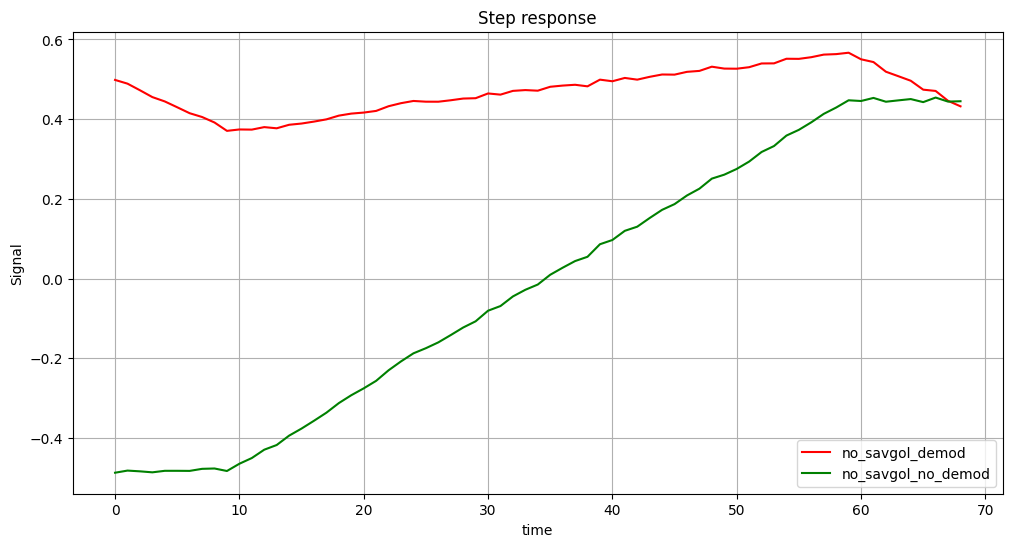

In [9]:
plt.figure(figsize=(12, 6)) 
plt.plot(no_savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(no_savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

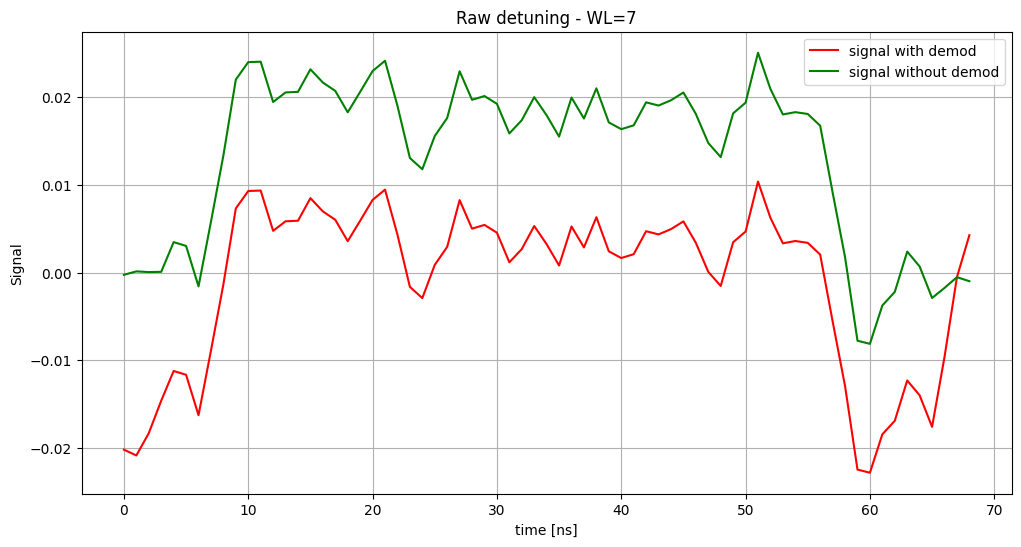

In [10]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="signal with demod")
plt.plot(savgol_no_demod, color = "green", label="signal without demod")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Raw detuning - WL=7")
plt.legend()
plt.grid()
plt.show()

In [12]:
#applicazione del filtro sui dati demodulati vs non demodulati, nearest, window length 7
_, _, savgol_demod = _fit(cryoscope_data, True, True, 7)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False, 7)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True, 7)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False, 7)

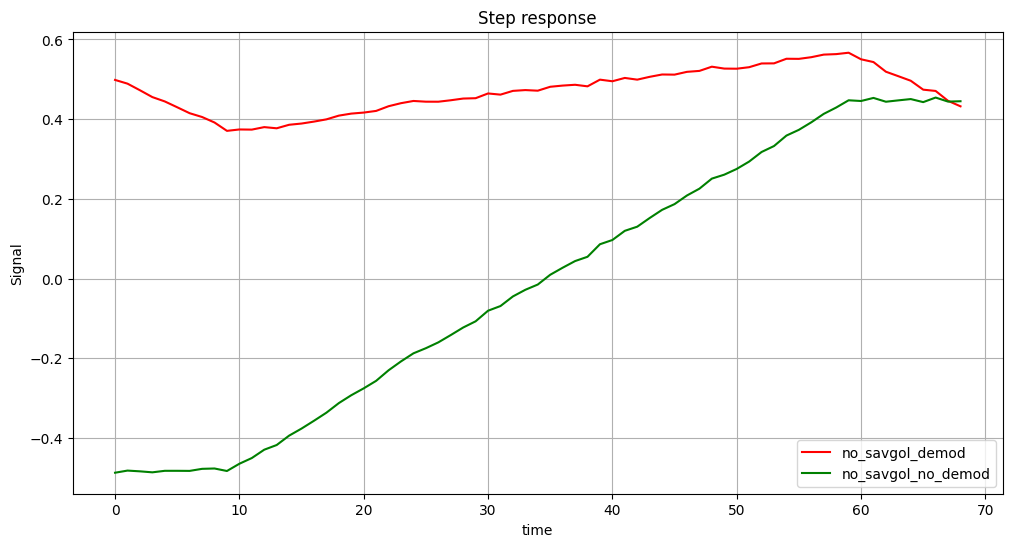

In [32]:
plt.figure(figsize=(12, 6)) 
plt.plot(no_savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(no_savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

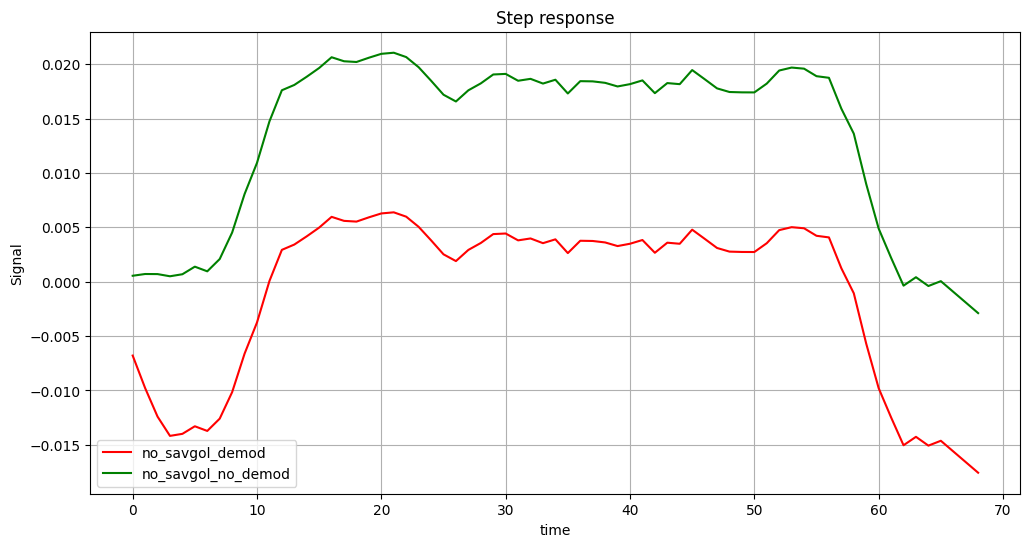

In [33]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()